# Assignment 3

Deadline: 09.04.2025 12:00 CET



Nils Winkler, 24-744-542, nilschristian.winkler@uzh.ch

Andi Vjerdha, 24-745-135,  andivjerdha00@gmail.com

Angus Martin, 24-745-747, angusalexander.martin@uzh.ch

Ipacs Kornel, 24-745-176, kornel.ipacs@uzh.ch



In [1]:
# Standard library imports
import os
import sys
import types

# Third party imports
import numpy as np
import pandas as pd

# Add the project root directory to Python path
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   #<Change this path if needed>
src_path = os.path.join(project_root, 'qpmwp-course/src')
sys.path.append(project_root)
sys.path.append(src_path)

# Local modules imports
from helper_functions import load_data_msci
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.optimization import MeanVariance
from backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from backtesting.backtest_item_builder_functions import (
    bibfn_selection_data_random,
    bibfn_return_series,
    bibfn_budget_constraint,
    bibfn_box_constraints,
)
from backtesting.portfolio import floating_weights
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest

### Data load

In [3]:
N = 24
data = load_data_msci(path = '../data/', n = N)

### Prepare backtest service

In [4]:
# Define rebalancing dates
n_days = 21 * 3
start_date = '2010-01-01'
dates = data['return_series'].index
rebdates = dates[dates > start_date][::n_days].strftime('%Y-%m-%d').tolist()

# Define the selection item builders.
selection_item_builders = {
    'data': SelectionItemBuilder(
        bibfn = bibfn_selection_data_random,
        k = 10,
        seed = 42,
    ),
}

# Define the optimization item builders.
optimization_item_builders = {
    'return_series': OptimizationItemBuilder(
        bibfn = bibfn_return_series,
        width = 365 * 3,
    ),
    'budget_constraint': OptimizationItemBuilder(
        bibfn = bibfn_budget_constraint,
        budget = 1,
    ),
    'box_constraints': OptimizationItemBuilder(
        bibfn = bibfn_box_constraints,
        upper = 0.5,
    ),
}

# Initialize the backtest service
bs = BacktestService(
    data = data,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    optimization = MeanVariance(
        covariance = Covariance(method = 'pearson'),
        expected_return = ExpectedReturn(method = 'geometric'),
        risk_aversion = 1,
        solver_name = 'cvxopt',
    ),
    rebdates = rebdates,
)

### Run the backtest

In [5]:
# Instantiate the backtest object and run the backtest
bt_mv = Backtest()

# Run the backtest
bt_mv.run(bs = bs)

Rebalancing date: 2010-01-04
Rebalancing date: 2010-04-01
Rebalancing date: 2010-06-29
Rebalancing date: 2010-09-24
Rebalancing date: 2010-12-22
Rebalancing date: 2011-03-21
Rebalancing date: 2011-06-16
Rebalancing date: 2011-09-13
Rebalancing date: 2011-12-09
Rebalancing date: 2012-03-07
Rebalancing date: 2012-06-04
Rebalancing date: 2012-08-30
Rebalancing date: 2012-11-27
Rebalancing date: 2013-02-22
Rebalancing date: 2013-05-22
Rebalancing date: 2013-08-19
Rebalancing date: 2013-11-14
Rebalancing date: 2014-02-11
Rebalancing date: 2014-05-09
Rebalancing date: 2014-08-06
Rebalancing date: 2014-11-03
Rebalancing date: 2015-01-29
Rebalancing date: 2015-04-28
Rebalancing date: 2015-07-24
Rebalancing date: 2015-10-21
Rebalancing date: 2016-01-18
Rebalancing date: 2016-04-14
Rebalancing date: 2016-07-12
Rebalancing date: 2016-10-07
Rebalancing date: 2017-01-04
Rebalancing date: 2017-04-03
Rebalancing date: 2017-06-29
Rebalancing date: 2017-09-26
Rebalancing date: 2017-12-22
Rebalancing da

## 1. Turnover

**(6 points)**

Complete the function `turnover`.

In [6]:

def turnover(self, return_series: pd.DataFrame, rescale: bool=True):

    dates = self.get_rebalancing_dates()
    to = {}
    to[dates[0]] = float(1)
    for rebalancing_date in dates[1:]:

        previous_portfolio = self.get_previous_portfolio(rebalancing_date)
        current_portfolio = self.get_portfolio(rebalancing_date)
        
        if current_portfolio.rebalancing_date is None or previous_portfolio.rebalancing_date is None:
            raise ValueError('Portfolios must have a rebalancing date')

        if current_portfolio.rebalancing_date < previous_portfolio.rebalancing_date:
            raise ValueError('The previous portfolio must be older than the current portfolio')

        # Get the union of the ids of the weights in both portfolios (previous and current)
        # <your code here>
        previous_weights = previous_portfolio.get_weights_series()
        current_weights = current_portfolio.get_weights_series()
        all_ids = previous_weights.index.union(current_weights.index)

        # Extend the weights of the previous portfolio to the the union of ids in both portfolios by adding zeros
        # <your code here>
        previous_weights = previous_weights.reindex(all_ids, fill_value=0)

        # Float the weights of the previous portfolio according to the price drifts in the market 
        # until the current rebalancing date
        # Hint: use function floating_weights from module portfolio.py
        # <your code here> 
        floated_weights = floating_weights(
            X=return_series,
            w=previous_weights,
            start_date=previous_portfolio.rebalancing_date,
            end_date=current_portfolio.rebalancing_date,
            rescale=rescale
        )

        floated_weights = floated_weights.loc[current_portfolio.rebalancing_date]

        # Extract the weights of the current portfolio
        # <your code here>
        current_weights = current_weights.reindex(all_ids, fill_value=0)

        # Calculate the turnover
        # <your code here>
        to[rebalancing_date] = (floated_weights - current_weights).abs().sum()

    return pd.Series(to)


2: Simulation

(6 points)

Complete the function `simulate`.

In [7]:
def simulate(self,
                return_series: pd.DataFrame,
                fc: float = 0,
                vc: float = 0,
                n_days_per_year: int = 365) -> pd.Series:

    rebdates = self.get_rebalancing_dates()
    ret_list = []
    for rebdate in rebdates:
        next_rebdate = (
            rebdates[rebdates.index(rebdate) + 1]
            if rebdate < rebdates[-1]
            else return_series.index[-1]
        )

        portfolio = self.get_portfolio(rebdate)
        w_float = portfolio.float_weights(
            return_series=return_series,
            end_date=next_rebdate,
            rescale=False # Notice that rescale is hardcoded to False.
        )
        level = w_float.sum(axis=1)
        ret_tmp = level.pct_change(1)
        ret_list.append(ret_tmp)

    portf_ret = pd.concat(ret_list).dropna()

    if vc != 0:
        # Calculate turnover
        to = self.turnover(return_series=return_series,
                           rescale=False)
        # Calculate variable cost (vc) as a fraction of turnover and
        # subtract the variable cost from the returns at each rebalancing date

        # <your code here>
        var_costs = vc * to 
        var_costs.index = pd.to_datetime(var_costs.index)
        var_costs = var_costs.reindex(portf_ret.index, fill_value=0)
        portf_ret -= var_costs

    if fc != 0:
        # Calculate number of days between returns
        # Calculate daily fixed cost based on the annual fixed cost (fc),
        # the number of days between two rebalancings and the number of days per year.
        # Subtract the daily fixed cost from the daily returns
        
        # <your code here>
        days_between = portf_ret.index.to_series().diff().dt.days.fillna(0)
        daily_fc = fc / n_days_per_year
        fixed_costs = days_between * daily_fc
        portf_ret -= fixed_costs.values
    
    return portf_ret

Overwrite the turnover and the simulation methods of the current strategy object.

In [8]:
# Overwrite the turnover method of the strategy object
bt_mv.strategy.turnover = types.MethodType(turnover, bt_mv.strategy)

# Overwrite the simulate method of the strategy object
bt_mv.strategy.simulate = types.MethodType(simulate, bt_mv.strategy)

Calculate and plot the turnover.

<Axes: title={'center': 'Turnover'}>

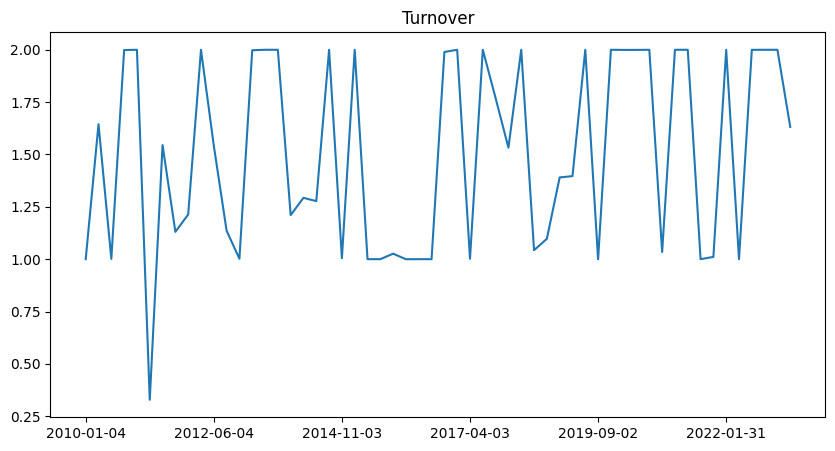

In [9]:
bt_mv.strategy.turnover(
    return_series = data['return_series'],
    rescale = True,
).plot(title = 'Turnover', figsize = (10, 5))


Simulate with different cost assumptions.

In [10]:
return_series = bs.data['return_series']

sim_mv_gross = bt_mv.strategy.simulate(return_series=return_series, fc=0, vc=0)
sim_mv_net_of_fc = bt_mv.strategy.simulate(return_series=return_series, fc=0.01, vc=0)
sim_mv_net_of_vc = bt_mv.strategy.simulate(return_series=return_series, fc=0, vc=0.002)
sim_mv_net = bt_mv.strategy.simulate(return_series=return_series, fc=0.01, vc=0.002)


Plot the cumulative returns.

<Axes: xlabel='Index'>

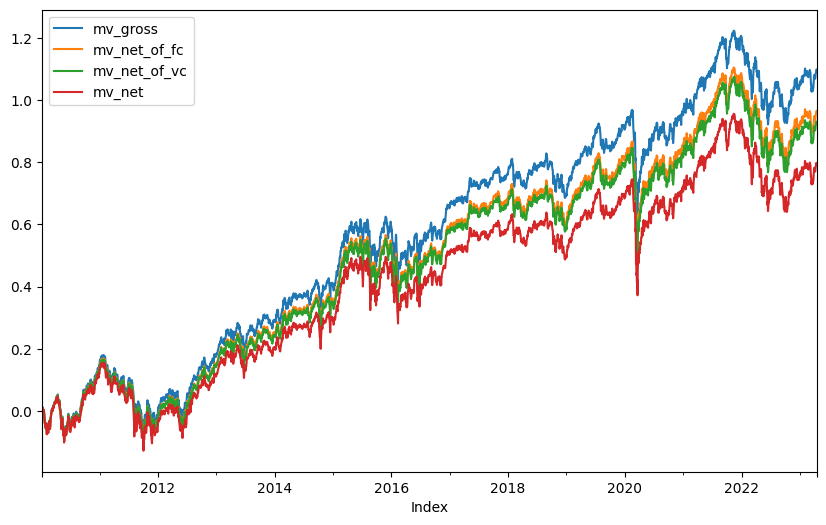

In [11]:
sim = pd.concat({
    'mv_gross': sim_mv_gross,
    'mv_net_of_fc': sim_mv_net_of_fc,
    'mv_net_of_vc': sim_mv_net_of_vc,
    'mv_net': sim_mv_net,
}, axis = 1).dropna()

np.log((1 + sim)).cumsum().plot(figsize = (10, 6))

3: Descriptive Statistics

(3 points)

Generate a table with descriptive statistics of the simulations. Include the following statistics:
- cumulative return (i.e., the return over the entire simulation period)
- annualized average returns
- annualized volatility
- sharpe ratio
- maximum drawdown

In [12]:
# <your code here>
def calculate_statistics(simulation: pd.Series, risk_free_rate: float = 0.02, days_per_year: int = 252):
    
    # Cumulative return
    cumulative_return = (1 + simulation).prod() - 1

    # Annualized average return
    growth_factor = cumulative_return + 1          
    n = simulation.shape[0]                         
    annualized_return = growth_factor**(days_per_year/n) - 1

    # Annualized volatility
    annualized_volatility = simulation.std() * np.sqrt(days_per_year)
    
    # Sharpe ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    # Maximum drawdown
    cumulative_returns = (1 + simulation).cumprod()
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    max_drawdown = drawdown.min()

    return pd.Series({
        "Cumulative Return": cumulative_return,
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Maximum Drawdown": max_drawdown
    })

simulations = {
    "Gross": sim_mv_gross,
    "Net of Fixed Costs": sim_mv_net_of_fc,
    "Net of Variable Costs": sim_mv_net_of_vc,
    "Net": sim_mv_net
}

stats_table = pd.DataFrame({name: calculate_statistics(sim) for name, sim in simulations.items()})

print(stats_table)

                          Gross  Net of Fixed Costs  Net of Variable Costs  \
Cumulative Return      1.997802            1.624769               1.530690   
Annualized Return      0.083095            0.072681               0.069838   
Annualized Volatility  0.147436            0.147443               0.147556   
Sharpe Ratio           0.427950            0.357296               0.337756   
Maximum Drawdown      -0.307494           -0.308135              -0.310316   

                            Net  
Cumulative Return      1.215769  
Annualized Return      0.059551  
Annualized Volatility  0.147564  
Sharpe Ratio           0.268025  
Maximum Drawdown      -0.310954  
